# TBOE Machine Learning for Everyone - Session 2

Notebook to accompanying Session 2 slides covering:
- Introduction to decision trees
- Binary classification metrics
- Cross-validation

In [1]:
import numpy as np
import pandas as pd

%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_text
from sklearn.datasets import load_breast_cancer
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score

from matplotlib.colors import ListedColormap

from collections import Counter
from pprint import pprint

## Simple split

In [2]:
np.random.seed(556)

n = 100
n_half = n // 2

X = []
y = []

# Negative targets
for i in range(n_half):
    X.append(
        [
            np.random.normal(loc=-1, scale=0.4),
            np.random.normal(loc=0, scale=0.4),
        ]
    )
    y.append(0)

# Positive targets
for i in range(n_half):
    X.append(
        [
            np.random.normal(loc=1, scale=0.4),
            np.random.normal(loc=0, scale=0.4),
        ]
    )
    y.append(1)
    
X = np.asarray(X)
X.shape

(100, 2)

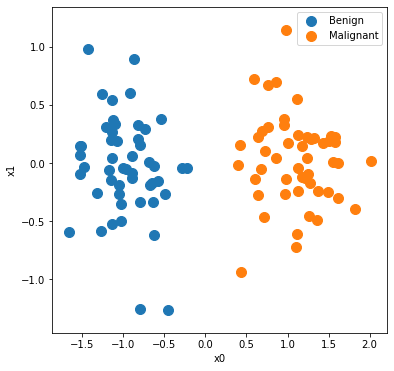

In [3]:
plt.figure(figsize=(6, 6))

x_min, x_max = X[:, 0].min() - 0.2, X[:, 0].max() + 0.2
y_min, y_max = X[:, 1].min() - 0.2, X[:, 1].max() + 0.2

plt.scatter(X[:n_half, 0], X[:n_half, 1], marker="o", s=100, label="Benign")
plt.scatter(X[n_half:, 0], X[n_half:, 1], marker="o", s=100, label="Malignant")
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xlabel("x0")
plt.ylabel("x1")
plt.legend()

In [4]:
cmap = sns.diverging_palette(220, 28, s=100.0, l=60, n=15, as_cmap=True)

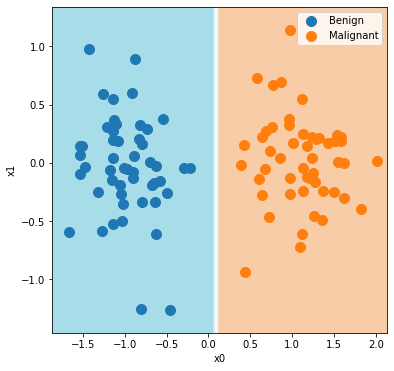

In [5]:
# Fit a decision tree with a single split
clf = DecisionTreeClassifier(max_depth=1, criterion="entropy")
clf.fit(X, y)


# One figure to plot
plt.figure(figsize=(6, 6))


# Now plot the decision boundary using a fine mesh as input to a
# filled contour plot
x_min, x_max = X[:, 0].min() - 0.2, X[:, 0].max() + 0.2
y_min, y_max = X[:, 1].min() - 0.2, X[:, 1].max() + 0.2
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))


Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.contourf(xx, yy, Z, alpha=0.4, cmap=cmap)

# Data set overlay
plt.scatter(X[:n_half, 0], X[:n_half, 1], marker="o", s=100, label="Benign")
plt.scatter(X[n_half:, 0], X[n_half:, 1], marker="o", s=100, label="Malignant")

plt.xlabel("x0")
plt.ylabel("x1")
plt.legend()

[Text(167.4, 163.07999999999998, 'x0 <= 0.086\nentropy = 1.0\nsamples = 100\nvalue = [50, 50]'),
 Text(83.7, 54.360000000000014, 'entropy = 0.0\nsamples = 50\nvalue = [50, 0]'),
 Text(251.10000000000002, 54.360000000000014, 'entropy = 0.0\nsamples = 50\nvalue = [0, 50]')]

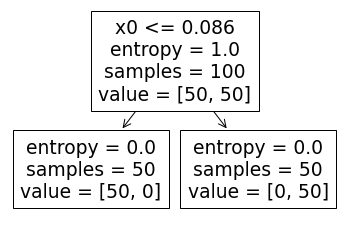

In [6]:
tree.plot_tree(clf, feature_names=["x0", "x1"])

In [7]:
text = export_text(clf, feature_names=["x0", "x1"])
print(text)

|--- x0 <= 0.09
|   |--- class: 0
|--- x0 >  0.09
|   |--- class: 1



### Information gain calculation

In [8]:
def compute_entropy(y):
    count_y = Counter(y)
    N = len(y)
    N_0 = count_y[0]
    N_1 = count_y[1]
    p_0 = N_0 / N
    p_1 = N_1 / N
    
    epsilon = 1e-8
    H = -p_0 * np.log2(p_0 + epsilon) - p_1 * np.log2(p_1 + epsilon)
    
    return H

In [9]:
H_parent = compute_entropy(y)
N = len(y)

col_to_split_val_ig = dict()
for i_col in range(X.shape[1]):
    
    split_val_ig = list()
    
    sorted_x_y = sorted(zip(list(X[:, i_col]), list(y)))
    for i in range(1, len(sorted_x_y)):
        left_x, left_y = zip(*sorted_x_y[:i])
        right_x, right_y = zip(*sorted_x_y[i:])

        split_x_mean = (left_x[-1] + right_x[0]) / 2

        H_left = compute_entropy(left_y)
        H_right = compute_entropy(right_y)
        IG = H_parent - ((len(left_y) / N) * H_left + (len(right_y) / N) * H_right)

        split_val_ig.append((split_x_mean, IG))

    col_to_split_val_ig[i_col] = np.asarray(split_val_ig)

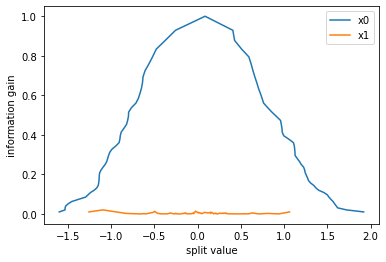

In [10]:
plt.figure(figsize=(6, 4))

plt.plot(col_to_split_val_ig[0][:, 0], col_to_split_val_ig[0][:, 1], label="x0")
plt.plot(col_to_split_val_ig[1][:, 0], col_to_split_val_ig[1][:, 1], label="x1")

plt.xlabel("split value")
plt.ylabel("information gain")
plt.legend()

## Rotated split

In [11]:
n = 100
n_half = n // 2

X = []
y = []

# Negative targets
for i in range(n_half):
    X.append(
        [
            np.random.normal(loc=-1, scale=0.4),
            np.random.normal(loc=0, scale=0.8),
        ]
    )
    y.append(0)

# Positive targets
for i in range(n_half):
    X.append(
        [
            np.random.normal(loc=1, scale=0.4),
            np.random.normal(loc=0, scale=0.8),
        ]
    )
    y.append(1)
    
X = np.asarray(X)


theta = np.pi / 4
rot = np.asarray([
    [np.cos(theta), -np.sin(theta)],
    [np.sin(theta), np.cos(theta)]
])

X = X.dot(rot)

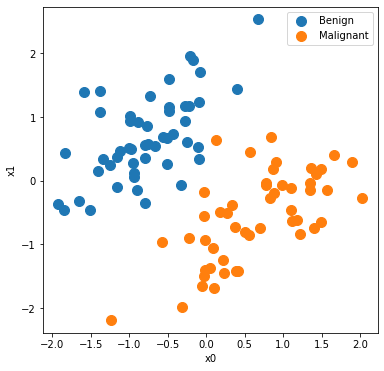

In [12]:
plt.figure(figsize=(6, 6))

x_min, x_max = X[:, 0].min() - 0.2, X[:, 0].max() + 0.2
y_min, y_max = X[:, 1].min() - 0.2, X[:, 1].max() + 0.2

plt.scatter(X[:n_half, 0], X[:n_half, 1], marker="o", s=100, label="Benign")
plt.scatter(X[n_half:, 0], X[n_half:, 1], marker="o", s=100, label="Malignant")
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xlabel("x0")
plt.ylabel("x1")
plt.legend()

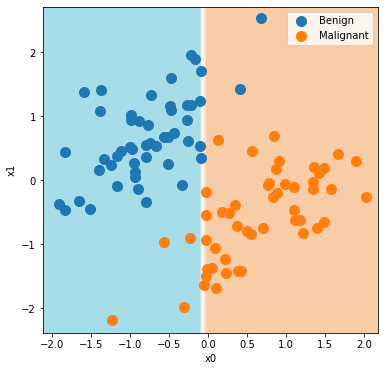

In [13]:
# Fit a decision tree with a single split
clf = DecisionTreeClassifier(max_depth=1, criterion="entropy")
clf.fit(X, y)


# One figure to plot
plt.figure(figsize=(6, 6))


# Now plot the decision boundary using a fine mesh as input to a
# filled contour plot
x_min, x_max = X[:, 0].min() - 0.2, X[:, 0].max() + 0.2
y_min, y_max = X[:, 1].min() - 0.2, X[:, 1].max() + 0.2
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))


Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

cmap = sns.diverging_palette(220, 28, s=100.0, l=60, sep=1, as_cmap=True)
plt.contourf(xx, yy, Z, alpha=0.4, cmap=cmap)

# Data set overlay
plt.scatter(X[:n_half, 0], X[:n_half, 1], marker="o", s=100, label="Benign")
plt.scatter(X[n_half:, 0], X[n_half:, 1], marker="o", s=100, label="Malignant")

plt.xlabel("x0")
plt.ylabel("x1")
plt.legend()

[Text(167.4, 163.07999999999998, 'x0 <= -0.071\nentropy = 1.0\nsamples = 100\nvalue = [50, 50]'),
 Text(83.7, 54.360000000000014, 'entropy = 0.391\nsamples = 52\nvalue = [48, 4]'),
 Text(251.10000000000002, 54.360000000000014, 'entropy = 0.25\nsamples = 48\nvalue = [2, 46]')]

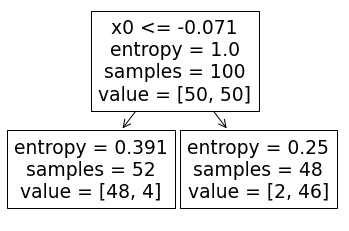

In [14]:
tree.plot_tree(clf, feature_names=["x0", "x1"])

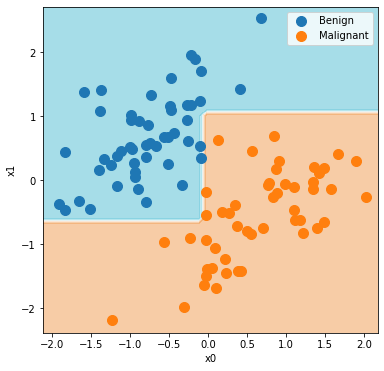

In [15]:
# Fit a decision tree with a single split
clf = DecisionTreeClassifier(max_depth=2, criterion="entropy")
clf.fit(X, y)


# One figure to plot
plt.figure(figsize=(6, 6))


# Now plot the decision boundary using a fine mesh as input to a
# filled contour plot
x_min, x_max = X[:, 0].min() - 0.2, X[:, 0].max() + 0.2
y_min, y_max = X[:, 1].min() - 0.2, X[:, 1].max() + 0.2
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))


Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.contourf(xx, yy, Z, alpha=0.4, cmap=cmap)

# Data set overlay
plt.scatter(X[:n_half, 0], X[:n_half, 1], marker="o", s=100, label="Benign")
plt.scatter(X[n_half:, 0], X[n_half:, 1], marker="o", s=100, label="Malignant")

plt.xlabel("x0")
plt.ylabel("x1")
plt.legend()

[Text(223.2, 362.4, 'x0 <= -0.071\nentropy = 1.0\nsamples = 100\nvalue = [50, 50]'),
 Text(111.6, 217.44, 'x1 <= -0.68\nentropy = 0.391\nsamples = 52\nvalue = [48, 4]'),
 Text(55.8, 72.47999999999996, 'entropy = 0.0\nsamples = 4\nvalue = [0, 4]'),
 Text(167.39999999999998, 72.47999999999996, 'entropy = 0.0\nsamples = 48\nvalue = [48, 0]'),
 Text(334.79999999999995, 217.44, 'x1 <= 1.062\nentropy = 0.25\nsamples = 48\nvalue = [2, 46]'),
 Text(279.0, 72.47999999999996, 'entropy = 0.0\nsamples = 46\nvalue = [0, 46]'),
 Text(390.59999999999997, 72.47999999999996, 'entropy = 0.0\nsamples = 2\nvalue = [2, 0]')]

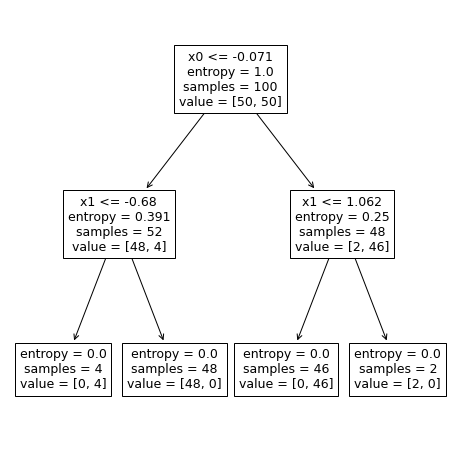

In [16]:
plt.figure(figsize=(8, 8))
tree.plot_tree(clf, feature_names=["x0", "x1"])

## Complex case

In [17]:
np.random.seed(114)

n = 200
n_half = n // 2
n_quarter = n // 4

X = []
y = []

# Negative targets
for i in range(n_half):
    X.append(
        [
            np.random.normal(loc=-0.8, scale=1),
            np.random.normal(loc=0.5, scale=2.1),
        ]
    )
    y.append(0)

# Positive targets
for i in range(n_quarter):
    X.append(
        [
            np.random.normal(loc=1, scale=0.6),
            np.random.normal(loc=0, scale=2),
        ]
    )
    y.append(1)
    X.append(
        [
            np.random.normal(loc=-1, scale=1.2),
            np.random.normal(loc=-2, scale=0.7),
        ]
    )
    y.append(1)
    
X = np.asarray(X)


theta = np.pi / 3
rot = np.asarray([
    [np.cos(theta), -np.sin(theta)],
    [np.sin(theta), np.cos(theta)]
])

X = X.dot(rot)

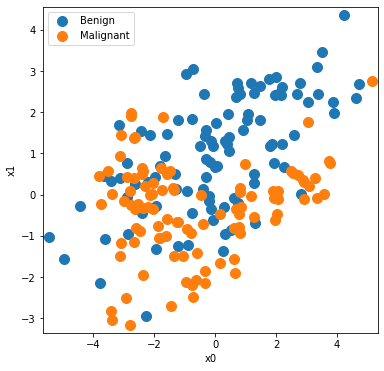

In [18]:
plt.figure(figsize=(6, 6))

x_min, x_max = X[:, 0].min() - 0.2, X[:, 0].max() + 0.2
y_min, y_max = X[:, 1].min() - 0.2, X[:, 1].max() + 0.2

plt.scatter(X[:n_half, 0], X[:n_half, 1], marker="o", s=100, label="Benign")
plt.scatter(X[n_half:, 0], X[n_half:, 1], marker="o", s=100, label="Malignant")
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xlabel("x0")
plt.ylabel("x1")
plt.legend()

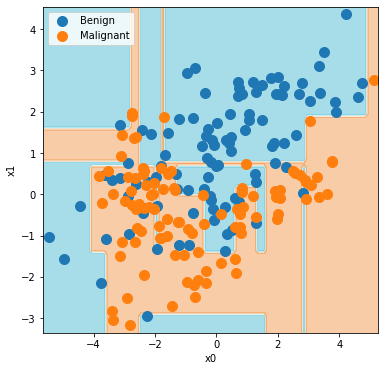

In [19]:
# Fit a decision tree with a single split
clf = DecisionTreeClassifier(max_depth=8, criterion="entropy")
clf.fit(X, y)


# One figure to plot
plt.figure(figsize=(6, 6))


# Now plot the decision boundary using a fine mesh as input to a
# filled contour plot
x_min, x_max = X[:, 0].min() - 0.2, X[:, 0].max() + 0.2
y_min, y_max = X[:, 1].min() - 0.2, X[:, 1].max() + 0.2
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))


Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.contourf(xx, yy, Z, alpha=0.4, cmap=cmap)

# Data set overlay
plt.scatter(X[:n_half, 0], X[:n_half, 1], marker="o", s=100, label="Benign")
plt.scatter(X[n_half:, 0], X[n_half:, 1], marker="o", s=100, label="Malignant")

plt.xlabel("x0")
plt.ylabel("x1")
plt.legend()

[Text(455.04507042253516, 821.4399999999999, 'x1 <= 0.657\nentropy = 1.0\nsamples = 200\nvalue = [100, 100]'),
 Text(262.4957746478873, 724.8, 'x0 <= -4.134\nentropy = 0.89\nsamples = 127\nvalue = [39, 88]'),
 Text(237.34647887323942, 628.16, 'entropy = 0.0\nsamples = 3\nvalue = [3, 0]'),
 Text(287.6450704225352, 628.16, 'x0 <= 1.599\nentropy = 0.869\nsamples = 124\nvalue = [36, 88]'),
 Text(160.32676056338028, 531.52, 'x1 <= -1.39\nentropy = 0.912\nsamples = 107\nvalue = [35, 72]'),
 Text(50.29859154929577, 434.88, 'x0 <= -3.588\nentropy = 0.454\nsamples = 21\nvalue = [2, 19]'),
 Text(25.149295774647886, 338.24, 'entropy = 0.0\nsamples = 1\nvalue = [1, 0]'),
 Text(75.44788732394366, 338.24, 'x1 <= -2.89\nentropy = 0.286\nsamples = 20\nvalue = [1, 19]'),
 Text(50.29859154929577, 241.60000000000002, 'x0 <= -2.539\nentropy = 0.918\nsamples = 3\nvalue = [1, 2]'),
 Text(25.149295774647886, 144.96000000000004, 'entropy = 0.0\nsamples = 2\nvalue = [0, 2]'),
 Text(75.44788732394366, 144.96000

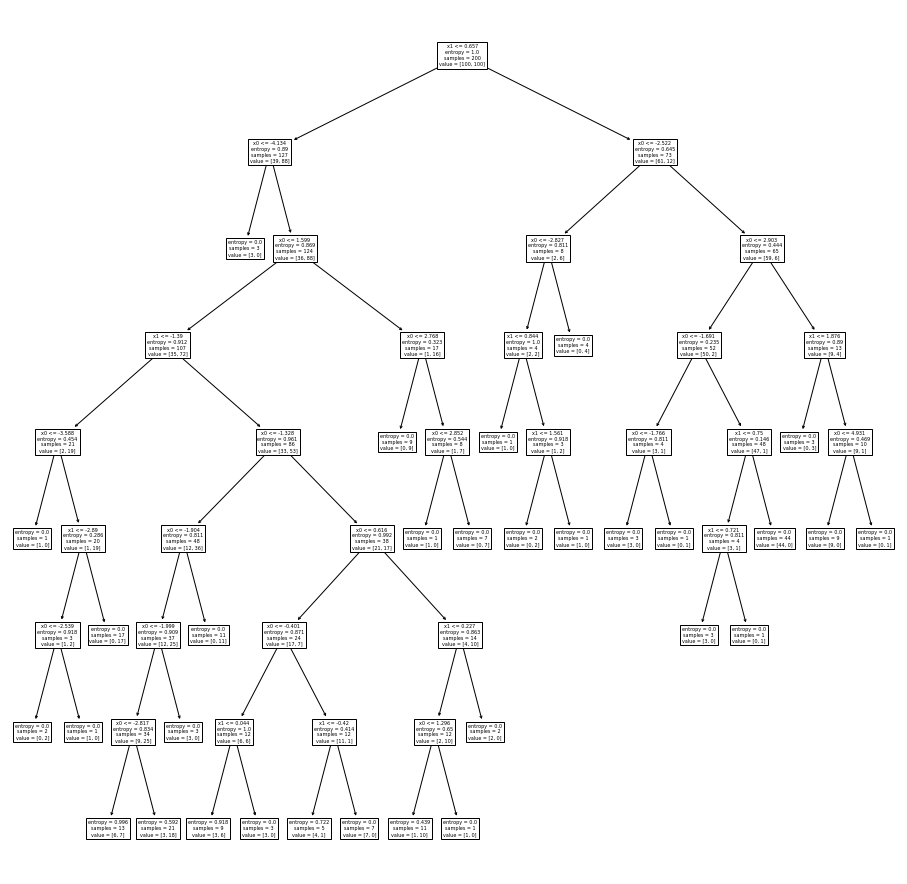

In [20]:
plt.figure(figsize=(16, 16))
tree.plot_tree(clf, feature_names=["x0", "x1"])

# Metrics

In [21]:
bc_data = load_breast_cancer()
bc_data.keys()

dict_keys(['data', 'target', 'target_names', 'DESCR', 'feature_names', 'filename'])

In [22]:
bc_data.target_names

array(['malignant', 'benign'], dtype='<U9')

In [23]:
X = bc_data.data
y = bc_data.target

In [24]:
X.shape, y.shape

((569, 30), (569,))

In [25]:
# swap y values so that malignant is 1
y = y ^ 1

In [26]:
Counter(y)

Counter({1: 212, 0: 357})

In [27]:
np.mean(y)

0.37258347978910367

In [28]:
def print_summary(y_true, y_pred):
    print("confusion matrix:")
    for row in confusion_matrix(y_true, y_pred).tolist():
        print(row)

    print()
    print(f"accuracy: {accuracy_score(y_true, y_pred):.4f}"
          f" precision: {precision_score(y_true, y_pred):.4f}"
          f" recall: {recall_score(y_true, y_pred):.4f}")


## Fit on all data

In [29]:
# Fit on all data
model = DecisionTreeClassifier(
    max_depth=7, 
    criterion="entropy"
)
model.fit(X, y)
y_pred = model.predict(X)
print_summary(y, y_pred)

confusion matrix:
[357, 0]
[0, 212]

accuracy: 1.0000 precision: 1.0000 recall: 1.0000


## Train/test split

In [30]:
from sklearn.model_selection import train_test_split

In [31]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20
)

model = DecisionTreeClassifier(
    max_depth=7, 
    criterion="entropy"
)
model.fit(X_train, y_train)

print("Training set:")
y_train_pred = model.predict(X_train)
print_summary(y_train, y_train_pred)

print("\nTest set:")
y_test_pred = model.predict(X_test)
print_summary(y_test, y_test_pred)

Training set:
confusion matrix:
[280, 0]
[0, 175]

accuracy: 1.0000 precision: 1.0000 recall: 1.0000

Test set:
confusion matrix:
[74, 3]
[7, 30]

accuracy: 0.9123 precision: 0.9091 recall: 0.8108


## 5-fold CV

In [32]:
from sklearn.model_selection import KFold
from collections import defaultdict

In [33]:
train_metrics, test_metrics = defaultdict(list), defaultdict(list)

kf = KFold(n_splits=5)
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    model = DecisionTreeClassifier(
        max_depth=7, 
        criterion="entropy"
    )
    model.fit(X_train, y_train)
    
    y_train_pred = model.predict(X_train)
    train_metrics["accuracy"].append(accuracy_score(y_train, y_train_pred))
    train_metrics["precision"].append(precision_score(y_train, y_train_pred))
    train_metrics["recall"].append(recall_score(y_train, y_train_pred))
    
    y_test_pred = model.predict(X_test)
    test_metrics["accuracy"].append(accuracy_score(y_test, y_test_pred))
    test_metrics["precision"].append(precision_score(y_test, y_test_pred))
    test_metrics["recall"].append(recall_score(y_test, y_test_pred))
    
print("Training set stats:")
for metric in ("accuracy", "precision", "recall"):
    print(f"{metric}: {np.mean(train_metrics[metric]):.4f} ({np.std(train_metrics[metric]):.4f})")
    
print("\nTest set stats:")
for metric in ("accuracy", "precision", "recall"):
    print(f"{metric}: {np.mean(test_metrics[metric]):.4f} ({np.std(test_metrics[metric]):.4f})")

Training set stats:
accuracy: 1.0000 (0.0000)
precision: 1.0000 (0.0000)
recall: 1.0000 (0.0000)

Test set stats:
accuracy: 0.9402 (0.0232)
precision: 0.9065 (0.0693)
recall: 0.9279 (0.0286)


## Leave-one-out CV

In [34]:
from sklearn.model_selection import LeaveOneOut

In [35]:
y_test_preds = list()

loo = LeaveOneOut()
for train_index, test_index in loo.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    model = DecisionTreeClassifier(
        max_depth=7, 
        criterion="entropy"
    )
    model.fit(X_train, y_train)
    
    y_test_pred = model.predict(X_test)
    y_test_preds.append(y_test_pred)

print("LOO test set:")
print_summary(y, y_test_preds)

LOO test set:
confusion matrix:
[338, 19]
[21, 191]

accuracy: 0.9297 precision: 0.9095 recall: 0.9009
